<a href="https://colab.research.google.com/github/gfgullo/AVSpeechSynthesizer-Example/blob/master/energy_consumption_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D

import matplotlib.pyplot as plt

In [45]:
WINDOW_SIZE = 30
BATCH_SIZE = 256

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!unzip household_power_consumption.zip

--2020-07-09 15:01:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip.1’

household_power_con 100%[===================>]  19.68M  48.5MB/s    in 0.4s    

2020-07-09 15:01:54 (48.5 MB/s) - ‘household_power_consumption.zip.1’ saved [20640916/20640916]

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: household_power_consumption.txt  


In [106]:
df = pd.read_csv("household_power_consumption.txt", sep=";")
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [107]:
series = df[["Date", "Global_active_power"]]
series["Date"] = pd.to_datetime(series["Date"])
series["Global_active_power"] = series["Global_active_power"][series["Global_active_power"]!="?"].astype(float)
series = (series.groupby("Date")).mean()
series = series.dropna()
print(series.count())
series.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Global_active_power    1433
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Global_active_power
Date,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


In [108]:
series.isna().sum()

Global_active_power    0
dtype: int64

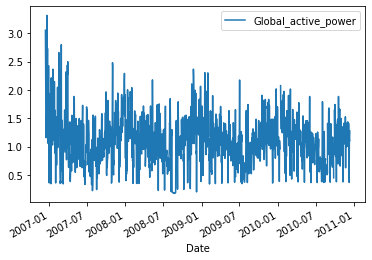

In [41]:
series.plot()

In [112]:
power_data = series["Global_active_power"].values

In [113]:
np.count_nonzero(np.isnan(power_data))

0

In [121]:
def get_xy(data, history_size, target_future=1):

    X = []
    y = []

    for i in range(0, data.shape[0]-history_size*target_future):
      X.append(np.reshape(data[i:i+history_size], (history_size, 1)))
      y.append(data[i+history_size*target_future])

    return np.array(X), np.array(y)


def train_test_split_series(X, y, test_size=0.25):

  samples_count = X.shape[0]
  sets_delimiter = samples_count-int((1-test_size)*samples_count)

  X_train = X[:sets_delimiter,:,:]
  X_test = X[sets_delimiter:,:,:]

  y_train = y[:sets_delimiter]
  y_test = y[sets_delimiter:]

  return X_train, X_test, y_train, y_test


def plot_series_prediction(y_true, y_pred, figsize=(16,10)):
  plt.figure(figsize=figsize)
  plt.grid()
  plt.plot(y_true, label="Temperatura reale")
  plt.plot(y_pred, label="Temperatura predetta")
  plt.legend()

In [116]:
X, y = get_xy(power_data, WINDOW_SIZE)
X_train, X_test, y_train, y_test = train_test_split_series(X, y)

X_train.shape

(351, 30, 1)

In [117]:
mean_value = X_train.mean()
std_value = X_train.std()

X_train = (X_train-mean_value)/std_value
X_test = (X_test-mean_value)/std_value

In [125]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences=True, input_shape=[WINDOW_SIZE,1], )))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
#model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

In [126]:
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE)

Epoch 1/50
2/2 [==============================] - 0s 36ms/step - loss: 1.1288
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 1.0711
Epoch 3/50
2/2 [==============================] - 0s 33ms/step - loss: 1.0173
Epoch 4/50
2/2 [==============================] - 0s 33ms/step - loss: 0.9725
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 0.9031
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 0.8208
Epoch 7/50
2/2 [==============================] - 0s 35ms/step - loss: 0.7246
Epoch 8/50
2/2 [==============================] - 0s 36ms/step - loss: 0.5998
Epoch 9/50
2/2 [==============================] - 0s 33ms/step - loss: 0.4868
Epoch 10/50
2/2 [==============================] - 0s 35ms/step - loss: 0.4679
Epoch 11/50
2/2 [==============================] - 0s 31ms/step - loss: 0.5044
Epoch 12/50
2/2 [==============================] - 0s 32ms/step - loss: 0.4993
Epoch 13/50
2/2 [==============================] - 0s 32ms/st

In [127]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 12ms/step - loss: 0.2615


0.26148882508277893

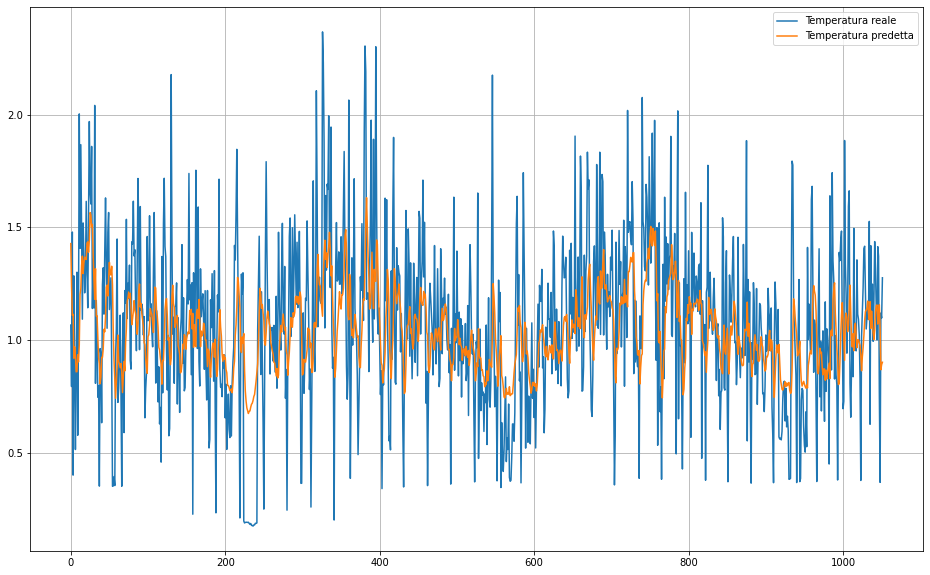

In [128]:
y_pred = model.predict(X_test)
plot_series_prediction(y_test, y_pred)

In [133]:
y_test[:100]

array([[1.06573056],
       [0.79296944],
       [1.47850833],
       [0.40000972],
       [1.28394167],
       [0.84391667],
       [0.51359444],
       [0.86632639],
       [1.30025278],
       [0.57673472],
       [1.12259583],
       [2.00254065],
       [1.40620278],
       [1.86591111],
       [1.48323056],
       [1.0918625 ],
       [1.51874167],
       [1.3752125 ],
       [1.20858889],
       [1.29097083],
       [1.61459583],
       [1.30715833],
       [1.14237639],
       [1.55545556],
       [1.96874167],
       [1.65400417],
       [1.60291389],
       [1.85835   ],
       [1.1393375 ],
       [1.35689028],
       [1.14174028],
       [2.0403294 ],
       [0.80710139],
       [1.17477222],
       [1.04011667],
       [0.74584167],
       [0.79666806],
       [0.35123333],
       [0.96121806],
       [0.93426528],
       [0.63237083],
       [1.24544722],
       [1.31979028],
       [1.11432083],
       [1.39250556],
       [1.629825  ],
       [1.34261667],
       [1.051

In [134]:
y_pred[:100]

array([[1.4272641 ],
       [1.2361956 ],
       [1.109345  ],
       [1.1132714 ],
       [0.918674  ],
       [0.96894705],
       [0.9284838 ],
       [0.85837567],
       [0.8591222 ],
       [0.9339583 ],
       [0.90244246],
       [0.97861046],
       [1.2016805 ],
       [1.2280042 ],
       [1.3302802 ],
       [1.3714617 ],
       [1.2940475 ],
       [1.3421432 ],
       [1.3673291 ],
       [1.3626376 ],
       [1.3565942 ],
       [1.4294727 ],
       [1.4347788 ],
       [1.3888452 ],
       [1.4415188 ],
       [1.564668  ],
       [1.5535499 ],
       [1.5016669 ],
       [1.5121554 ],
       [1.3777797 ],
       [1.2671622 ],
       [1.1804447 ],
       [1.3158739 ],
       [1.1055033 ],
       [1.1079024 ],
       [1.020589  ],
       [0.9210971 ],
       [0.89488804],
       [0.8052463 ],
       [0.83541214],
       [0.9222921 ],
       [0.92221177],
       [0.9597237 ],
       [1.0472301 ],
       [1.0360644 ],
       [1.1045774 ],
       [1.2335681 ],
       [1.242